In [195]:
import math
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
class Value:
  
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.
  })"
  
  def __add__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')
    
    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    
    return out

  def __mul__(self, other):
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), '*')
    
    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
      
    return out
  
  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
        self.grad += other * (self.data ** (other - 1)) * out.grad
    out._backward = _backward

    return out
  
  def __rmul__(self, other): # other * self
    return self * other

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def __radd__(self, other): # other + self
    return self + other

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1)/(math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')
    
    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    
    return out
  
  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')
    
    def _backward():
      self.grad += out.data * out.grad # NOTE: in the video I incorrectly used = instead of +=. Fixed here.
    out._backward = _backward
    
    return out
  
  
  def backward(self):
    
    topo = []#topological order 
    visited = set()#prevents visiting the same node twice
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)
    
    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [197]:

from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

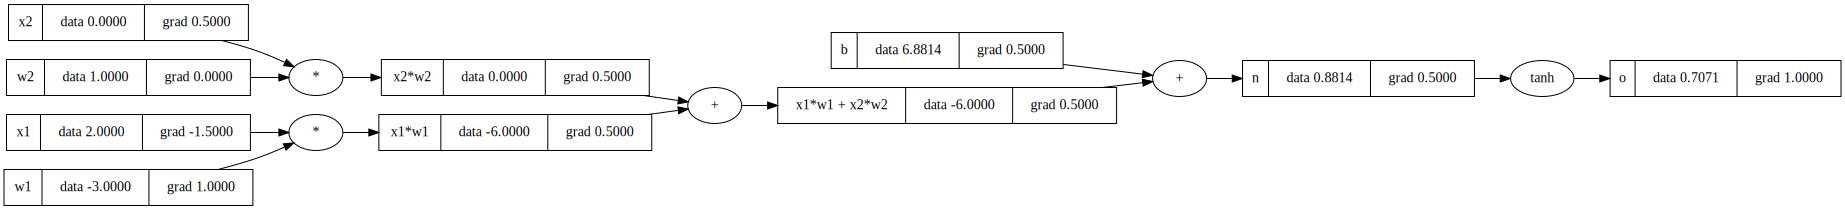

In [198]:
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()
draw_dot(o)

In [199]:
# a=Value(10,label='a')
# b=Value(5,label='b')
# a/b


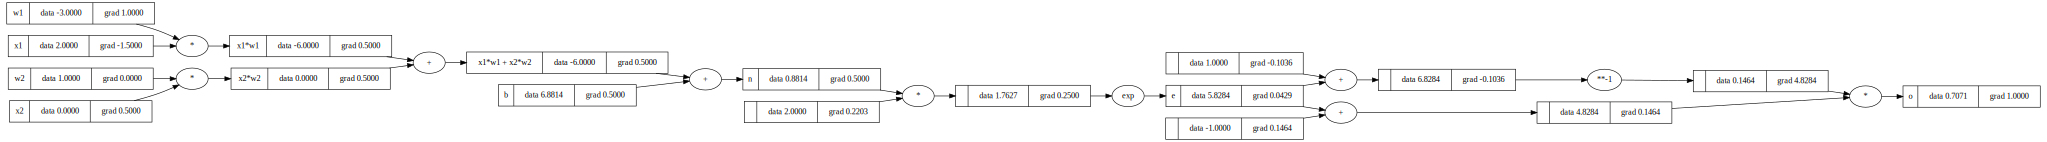

In [200]:
#NN
# inputs x1,x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,w2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
e=(2*n).exp();e.label='e'
o=(e-1)/(e+1)
o.label='o'
o.backward()
draw_dot(o)

In [201]:
### implementing the same in pytorch

import torch
x1=torch.Tensor([2.0]).double()
x1.requires_grad=True
x2=torch.Tensor([0.0]).double()
x2.requires_grad=True
w1=torch.Tensor([-3.0]).double()
w1.requires_grad=True
w2=torch.Tensor([1.0]).double()
w2.requires_grad=True
b=torch.Tensor([6.884]).double()
b.requires_grad=True
n = x1*w1+x2*w2 + b
o = torch.tanh(n)
print(o.data.item())
o.backward()

print("---")
print('x2',x2.grad.item())
print('x1',x1.grad.item())
print('w1',w1.grad.item())
print('w2',w2.grad.item())


0.7084174629496179
---
x2 0.4981446981880267
x1 -1.4944340945640802
w1 0.9962893963760534
w2 0.0


In [202]:
import random

In [203]:
class Neuron:
    def __init__(self,nin):
        self.w=[Value(random.uniform(-1,1)) for r in range(nin) ]
        self.b=Value(random.uniform(-1,1))
        
    def __call__(self,x):#make a class  call like a function
        # x*w+b
        act=sum((xi*wi for xi,wi in zip(self.w,x)),self.b) #sum function starts with 0.0 it we add with a comma
        out=act.tanh()
        return out
    
    def parameters(self):
        return self.w + [self.b]
    
class Layer:
    def __init__(self,nin,nout):
        self.neurons=[Neuron(nin) for _ in range(nout)]
        
    def __call__(self, x):
        outs=[n(x) for n in self.neurons]
        return outs[0] if len(outs)==1 else outs
    
    def parameters(self):
        return [p for neuron in self.neurons for p in neuron.parameters()]
        
        
    
class MLP:
    def __init__(self,nin:int,nouts:list):
        sz= [nin] + nouts
        self.layers=[Layer(sz[i],sz[i+1]) for i in range(len(nouts))]#storing the layers

    def __call__(self,x):
        for layer in self.layers:
            x=layer(x)#calling the layers
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()] 
    


In [204]:
x=[2.0,3.0,-1.0]#input
n=MLP(3,[4,4,1])
n(x)

Value(data=-0.39362726869502046)

In [205]:
len(n.parameters())

41

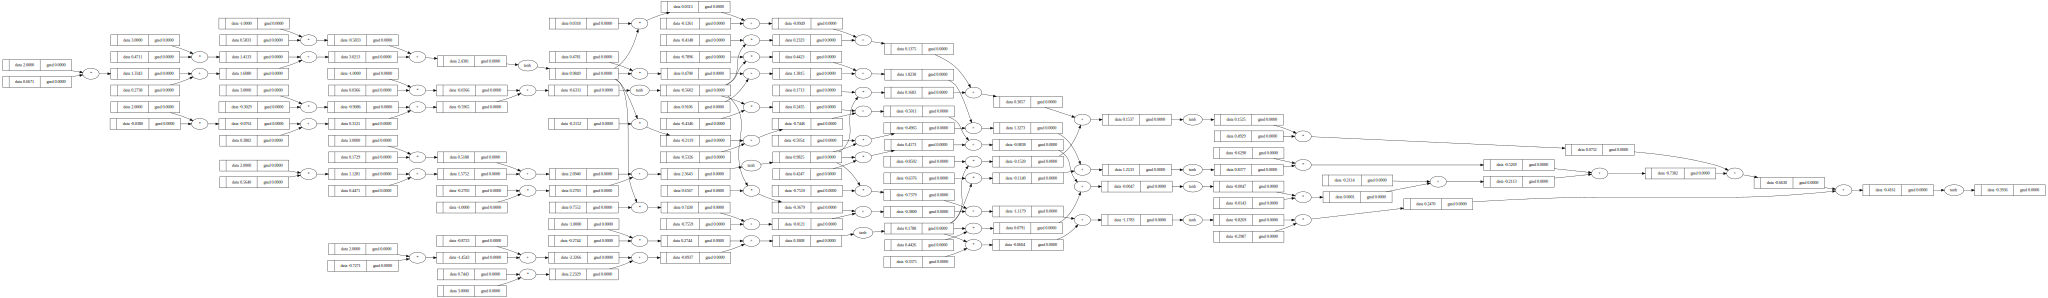

In [206]:
draw_dot(n(x))

In [207]:
xs = [
  [2.0, 3.0, -1.0],
  [3.0, -1.0, 0.5],
  [0.5, 1.0, 1.0],
  [1.0, 1.0, -1.0],
]
ys = [1.0, -1.0, -1.0, 1.0] # desired targets




In [208]:
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad
  
  print(k, loss.data)

0 4.310460128855196
1 3.0752819573395946
2 5.300249458391235
3 3.0617314330420755
4 2.4212999746584725
5 0.06507644277879185
6 0.04842505239292252
7 0.03937667173379244
8 0.033531733190620173
9 0.029376734684813742
10 0.02623658748679955
11 0.023760521850607296
12 0.021746508850088452
13 0.020069130632688347
14 0.018645942081740068
15 0.01742024105175693
16 0.01635157733078844
17 0.015410210343575733
18 0.014573713615175758
19 0.013824809059171494


In [230]:
#epoch training and degrading our lkoss
for k in range(20):
  
  # forward pass
  ypred = [n(x) for x in xs]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
  
  # backward pass
  for p in n.parameters():
    p.grad = 0.0
  loss.backward()
  
  # update
  for p in n.parameters():
    p.data += -0.1 * p.grad # tune 0.01(learning rate or step size  to improve or may be degrade  the model)
  
  print(k, loss.data)
print(ypred)

0 0.0005130140995239097
1 0.0005118135910854393
2 0.0005106185165921934
3 0.0005094288396940191
4 0.0005082445243620004
5 0.0005070655348849768
6 0.0005058918358660255
7 0.000504723392219059
8 0.0005035601691654021
9 0.0005024021322304848
10 0.0005012492472405183
11 0.0005001014803192133
12 0.0004989587978846336
13 0.0004978211666459409
14 0.0004966885536003182
15 0.0004955609260298354
16 0.0004944382514984207
17 0.000493320497848852
18 0.0004922076331997529
19 0.0004910996259426568
[Value(data=0.9894877064585645), Value(data=-0.9892117221612678), Value(data=-0.9902356441807023), Value(data=0.9870053192748025)]


In [210]:
#calculating the loss function(mse)
ypred=[n(x) for x in xs]
loss=sum([(yout-ygt)**2 for ygt,yout in zip(ys,ypred)])
# draw_dot(loss)
loss

Value(data=0.0066255987603326735)

In [211]:
loss.backward()

In [212]:
# draw_dot(loss)

In [213]:
n.layers[0].neurons[0].w[0].grad

0.004694859044873996

In [214]:
n.layers[0].neurons[0].w[0].data


0.4504830252772928

In [215]:
for p in n.parameters():
    p.data += -0.01 * p.grad # as we wanna minimize the loss
    #we can tune -0.01 to much greater(increasing step size or learning rate) but it may improve or decrease acu
    

In [216]:
n.layers[0].neurons[0].w[0].data # it has slighly increased 


0.45043607668684404

In [217]:
#calculating the loss function(mse)
ypred=[n(x) for x in xs]
loss=sum([(yout-ygt)**2 for ygt,yout in zip(ys,ypred)])
# draw_dot(loss)
loss## the loss has slightly decreased 

Value(data=0.006592305929315873)

### again decreased a bit ,continue doing it and we will gonna minized the loss to 0,and hence our weights are trained

In [218]:
loss.backward()
for p in n.parameters():
    p.data += -0.01 * p.grad # as we wanna minimize the loss


#calculating the loss function(mse)
ypred=[n(x) for x in xs]
loss=sum([(yout-ygt)**2 for ygt,yout in zip(ys,ypred)])
# draw_dot(loss)
loss

Value(data=0.006542948895457946)

In [219]:
ypred

[Value(data=0.959689682721536),
 Value(data=-0.9550110084825231),
 Value(data=-0.9661726632624736),
 Value(data=0.9581702361009066)]